### The 2d Darcy's Flow 
The Darcy's problem is given as:
\begin{equation}
\begin{cases}
- \nabla(\cdot a(x) \nabla u(x)) &= f(x), \quad x\in\Omega\\
       u  &=0, \quad x\in\partial\Omega
\end{cases}
\end{equation}
where $\Omega=[0,1]^2$. We consider the coefficient $a(x)$ with the following form:
\begin{equation}
a(x) = 2.1 + \sin(\beta_1 x_1) + \cos(\beta_2  x_2)
\end{equation}
where $\beta_1=5.0011, \beta_2=3.3723$.

### (1) Prepare the data

<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>


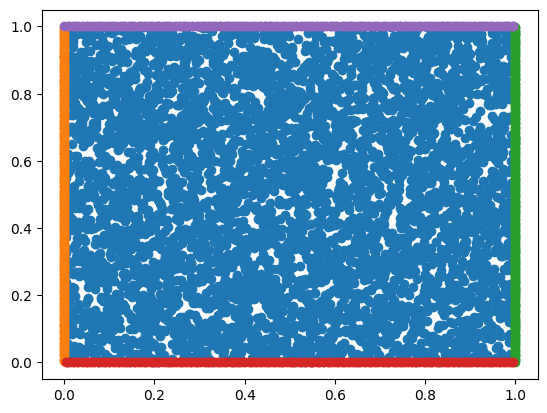

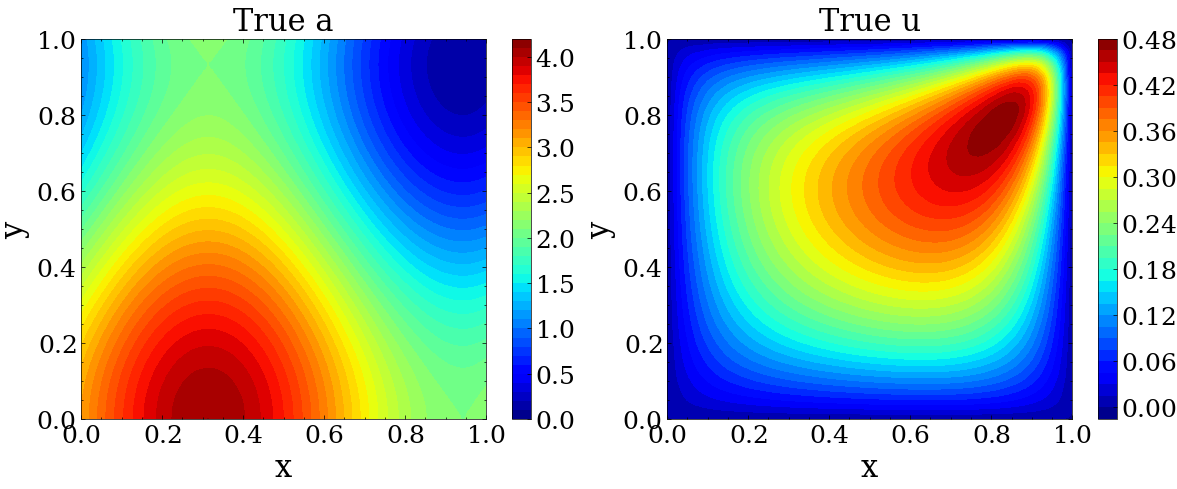

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 123
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
######################################
# Load reference data
######################################
from Utils.utils import *
data_test = h5py.File('../../Problems/Darcy_Flow/truth_cts_2d.mat', 'r')
print(data_test.keys())
#
def get_data(data, inx, dtype):
    a = np.array(data["coeff"][...,inx]).T
    u = np.array(data["sol"][...,inx]).T
    ux = np.array(data["soldx"][...,inx]).T
    uy = np.array(data["soldy"][...,inx]).T
    beta1 = np.array(data["beta1"][inx])
    beta2 = np.array(data["beta2"][inx])
    #
    X, Y = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np.vstack([X.ravel(), Y.ravel()]).T
    #
    a = a.reshape(-1, 1)
    u = u.reshape(-1, 1)
    ux = ux.reshape(-1, 1)
    uy = uy.reshape(-1, 1)
    
    return np2tensor(a, dtype), np2tensor(u, dtype), np2tensor(mesh, dtype), \
            np2tensor(ux, dtype), np2tensor(uy, dtype), np2tensor(beta1, dtype), np2tensor(beta2, dtype)
#
a_test, u_test, x_test, ux_test, uy_test, beta1, beta2 = get_data(data_test, 0, dtype)
######################################
# Generate training data
######################################
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
#
N_center, N_bd_each_edge = 5000, 200
xc, R = pointGen.weight_centers(n_center=N_center, R_max=1e-4, R_min=1e-4)
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='hypercube')
#
x_lt = x_bd_train[0:N_bd_each_edge]
x_rt = x_bd_train[N_bd_each_edge:2*N_bd_each_edge]
x_bt = x_bd_train[2*N_bd_each_edge:3*N_bd_each_edge]
x_up = x_bd_train[3*N_bd_each_edge:]
#########################################
plt.figure()
plt.scatter(xc[...,0], xc[...,1])
plt.scatter(x_lt[:,0], x_lt[:,1])
plt.scatter(x_rt[:,0], x_rt[:,1])
plt.scatter(x_bt[:,0], x_bt[:,1])
plt.scatter(x_up[:,0], x_up[:,1])
plt.show()
#######################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(x_test, [a_test, u_test], ['True a', 'True u'])

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, _, _ = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=15, 
    dataType=dtype).get_testFun()

###############################
# The coefficient function
###############################
class Fun_a(object):

    def __init__(self, betax, betay):
        self.betax = betax
        self.betay = betay
        
    def __call__(self, x):
        '''
        '''
        a = 2.1 + torch.sin(self.betax * x[...,0:1]) + torch.cos(self.betay * x[...,1:2])
        return a

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, grid):
        '''Define the mollifer
        '''
        x_mesh, y_mesh = grid[...,0:1], grid[...,1:2]
        u = u * torch.sin(np.pi * x_mesh)*torch.sin(np.pi * y_mesh)
        return u
    
##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.mollifer = mollifer()
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_a = Fun_a(beta1[0].to(self.device), beta2[0].to(self.device))
        self.model_u = solver.model_dict['u']
        ######################## 
        self.int_grid = int_grid.to(self.solver.device)
        self.n_grid = int_grid.shape[0]
        
    def Loss_pde(self, xc=None):
        '''Define the PDE loss
        '''
        nc = xc.shape[0]
        #############################################
        _, R = pointGen.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
        R = R.to(self.solver.device)
        #
        x = self.int_grid * R + xc
        x = Variable(x.reshape(-1, 2), requires_grad=True)
        ##########################################
        a = self.model_a(x)
        u = self.model_u(x)
        if self.mollifer is not None:
            u = self.mollifer(u, x)
        du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = 10. * torch.ones_like(u)
        ###########################################
        adu = a*du
        dauxdx = grad(inputs=x, outputs=adu[...,0:1], grad_outputs=torch.ones_like(adu[...,0:1]), 
                       create_graph=True)[0]
        dauydy = grad(inputs=x, outputs=adu[...,1:2], grad_outputs=torch.ones_like(adu[...,1:2]), 
                       create_graph=True)[0]
        left = (-dauxdx[...,0:1]-dauydy[...,1:2])
        right = f
        ###########################################
        loss = self.solver.getLoss(left, right)
        
        return loss * 1.

    def Loss_bd(self):
        ''' '''
        loss = torch.tensor(0., device=self.solver.device)
        
        return loss * 1.
        
    def Error(self):
        '''
        '''
        x = x_test.to(self.solver.device)
        u = u_test.to(self.solver.device)
        ####### 
        u_pred = self.model_u(x)
        if self.mollifer is not None:
            u_pred = self.mollifer(u_pred, x)
        #
        error = self.solver.getError(u_pred, u)

        return error

##########################################
from Solvers.PINN import PINN
#
solver = PINN.Solver(device, dtype=dtype)
model_u = solver.getModel([2, 40, 40, 40, 1], 'Tanh', netType='FCNet')

### (3) training and prediction

#### (3.1) Train the model

In [3]:
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', lbfgs=False, max_iter=1000)
solver.train(LossClass, xc, batch_size_in=50, epochs=1000, **{'save_path':'saved_models/cts/'})
# solver.train_lbfgs(LossClass, xc, epochs=200, **{'save_path':'saved_models/cts/'})

  1%|▌                                                       | 10/1000 [00:11<18:43,  1.14s/it]

Epoch:10 Time:11.8372, loss_in:3.360605, loss_bd:0.000000
    l2_err:0.2463933676481247, 
    lr:[0.001]


  2%|█                                                       | 20/1000 [00:21<13:51,  1.18it/s]

Epoch:20 Time:21.3780, loss_in:2.657237, loss_bd:0.000000
    l2_err:0.1628984957933426, 
    lr:[0.001]


  3%|█▋                                                      | 30/1000 [00:29<12:56,  1.25it/s]

Epoch:30 Time:29.3764, loss_in:2.711002, loss_bd:0.000000
    l2_err:0.18770429491996765, 
    lr:[0.001]


  4%|██▏                                                     | 40/1000 [00:37<12:48,  1.25it/s]

Epoch:40 Time:37.3654, loss_in:2.529611, loss_bd:0.000000
    l2_err:0.12720902264118195, 
    lr:[0.001]


  5%|██▊                                                     | 50/1000 [00:45<12:41,  1.25it/s]

Epoch:50 Time:45.3736, loss_in:1.761977, loss_bd:0.000000
    l2_err:0.11119480431079865, 
    lr:[0.001]


  6%|███▎                                                    | 60/1000 [00:53<12:33,  1.25it/s]

Epoch:60 Time:53.3829, loss_in:1.530211, loss_bd:0.000000
    l2_err:0.08617405593395233, 
    lr:[0.001]


  7%|███▉                                                    | 70/1000 [01:01<12:19,  1.26it/s]

Epoch:70 Time:61.3671, loss_in:1.518446, loss_bd:0.000000
    l2_err:0.09332671016454697, 
    lr:[0.001]


  8%|████▍                                                   | 80/1000 [01:09<12:15,  1.25it/s]

Epoch:80 Time:69.3680, loss_in:1.292436, loss_bd:0.000000
    l2_err:0.05808190628886223, 
    lr:[0.001]


  9%|█████                                                   | 90/1000 [01:17<12:10,  1.25it/s]

Epoch:90 Time:77.3739, loss_in:1.235085, loss_bd:0.000000
    l2_err:0.08100740611553192, 
    lr:[0.001]


 10%|█████▌                                                 | 100/1000 [01:25<12:05,  1.24it/s]

Epoch:100 Time:85.3961, loss_in:1.068263, loss_bd:0.000000
    l2_err:0.05208171531558037, 
    lr:[0.001]


 11%|██████                                                 | 110/1000 [01:32<11:00,  1.35it/s]

Epoch:110 Time:92.9994, loss_in:1.009153, loss_bd:0.000000
    l2_err:0.04023271054029465, 
    lr:[0.001]


 12%|██████▌                                                | 120/1000 [01:40<10:45,  1.36it/s]

Epoch:120 Time:100.3318, loss_in:0.975000, loss_bd:0.000000
    l2_err:0.04253317043185234, 
    lr:[0.001]


 13%|███████▏                                               | 130/1000 [01:47<10:38,  1.36it/s]

Epoch:130 Time:107.6693, loss_in:0.932192, loss_bd:0.000000
    l2_err:0.04249386861920357, 
    lr:[0.001]


 14%|███████▋                                               | 140/1000 [01:55<10:32,  1.36it/s]

Epoch:140 Time:115.0497, loss_in:0.847889, loss_bd:0.000000
    l2_err:0.032886702567338943, 
    lr:[0.001]


 15%|████████▎                                              | 150/1000 [02:02<10:24,  1.36it/s]

Epoch:150 Time:122.3861, loss_in:0.780650, loss_bd:0.000000
    l2_err:0.03260541707277298, 
    lr:[0.001]


 16%|████████▊                                              | 160/1000 [02:09<10:16,  1.36it/s]

Epoch:160 Time:129.7252, loss_in:0.687017, loss_bd:0.000000
    l2_err:0.02151728793978691, 
    lr:[0.001]


 17%|█████████▎                                             | 170/1000 [02:17<10:10,  1.36it/s]

Epoch:170 Time:137.0732, loss_in:0.886974, loss_bd:0.000000
    l2_err:0.03742232546210289, 
    lr:[0.001]


 18%|█████████▉                                             | 180/1000 [02:24<10:02,  1.36it/s]

Epoch:180 Time:144.4374, loss_in:0.680105, loss_bd:0.000000
    l2_err:0.014356859028339386, 
    lr:[0.001]


 19%|██████████▍                                            | 190/1000 [02:31<09:52,  1.37it/s]

Epoch:190 Time:151.7642, loss_in:0.646821, loss_bd:0.000000
    l2_err:0.025929832831025124, 
    lr:[0.001]


 20%|███████████                                            | 200/1000 [02:39<09:45,  1.37it/s]

Epoch:200 Time:159.0964, loss_in:0.579154, loss_bd:0.000000
    l2_err:0.010470577515661716, 
    lr:[0.0005]


 21%|███████████▌                                           | 210/1000 [02:46<09:38,  1.37it/s]

Epoch:210 Time:166.4244, loss_in:0.528828, loss_bd:0.000000
    l2_err:0.015133729204535484, 
    lr:[0.0005]


 22%|████████████                                           | 220/1000 [02:53<09:31,  1.37it/s]

Epoch:220 Time:173.7438, loss_in:0.500588, loss_bd:0.000000
    l2_err:0.01378622092306614, 
    lr:[0.0005]


 23%|████████████▋                                          | 230/1000 [03:01<09:25,  1.36it/s]

Epoch:230 Time:181.0888, loss_in:0.489006, loss_bd:0.000000
    l2_err:0.0198932196944952, 
    lr:[0.0005]


 24%|█████████████▏                                         | 240/1000 [03:08<09:17,  1.36it/s]

Epoch:240 Time:188.4323, loss_in:0.493453, loss_bd:0.000000
    l2_err:0.007816093973815441, 
    lr:[0.0005]


 25%|█████████████▊                                         | 250/1000 [03:15<09:09,  1.37it/s]

Epoch:250 Time:195.7681, loss_in:0.468084, loss_bd:0.000000
    l2_err:0.010651214979588985, 
    lr:[0.0005]


 26%|██████████████▎                                        | 260/1000 [03:23<09:03,  1.36it/s]

Epoch:260 Time:203.1130, loss_in:0.524586, loss_bd:0.000000
    l2_err:0.03321193531155586, 
    lr:[0.0005]


 27%|██████████████▊                                        | 270/1000 [03:30<08:59,  1.35it/s]

Epoch:270 Time:210.5108, loss_in:0.439646, loss_bd:0.000000
    l2_err:0.004688863176852465, 
    lr:[0.0005]


 28%|███████████████▍                                       | 280/1000 [03:37<08:49,  1.36it/s]

Epoch:280 Time:217.8566, loss_in:0.437359, loss_bd:0.000000
    l2_err:0.0071091060526669025, 
    lr:[0.0005]


 29%|███████████████▉                                       | 290/1000 [03:45<08:38,  1.37it/s]

Epoch:290 Time:225.1871, loss_in:0.431021, loss_bd:0.000000
    l2_err:0.012755410745739937, 
    lr:[0.0005]


 30%|████████████████▌                                      | 300/1000 [03:52<08:32,  1.36it/s]

Epoch:300 Time:232.4875, loss_in:0.417320, loss_bd:0.000000
    l2_err:0.006743760779500008, 
    lr:[0.0005]


 31%|█████████████████                                      | 310/1000 [03:59<08:22,  1.37it/s]

Epoch:310 Time:239.7664, loss_in:0.413794, loss_bd:0.000000
    l2_err:0.00445814523845911, 
    lr:[0.0005]


 32%|█████████████████▌                                     | 320/1000 [04:07<08:15,  1.37it/s]

Epoch:320 Time:247.0609, loss_in:0.448112, loss_bd:0.000000
    l2_err:0.011284643784165382, 
    lr:[0.0005]


 33%|██████████████████▏                                    | 330/1000 [04:14<08:08,  1.37it/s]

Epoch:330 Time:254.3490, loss_in:0.431491, loss_bd:0.000000
    l2_err:0.014086578041315079, 
    lr:[0.0005]


 34%|██████████████████▋                                    | 340/1000 [04:21<08:02,  1.37it/s]

Epoch:340 Time:261.6473, loss_in:0.402023, loss_bd:0.000000
    l2_err:0.004739487078040838, 
    lr:[0.0005]


 35%|███████████████████▎                                   | 350/1000 [04:28<07:56,  1.36it/s]

Epoch:350 Time:268.9478, loss_in:0.416476, loss_bd:0.000000
    l2_err:0.010194829665124416, 
    lr:[0.0005]


 36%|███████████████████▊                                   | 360/1000 [04:36<07:34,  1.41it/s]

Epoch:360 Time:276.1256, loss_in:0.396782, loss_bd:0.000000
    l2_err:0.011489472351968288, 
    lr:[0.0005]


 37%|████████████████████▎                                  | 370/1000 [04:43<07:24,  1.42it/s]

Epoch:370 Time:283.1796, loss_in:0.384271, loss_bd:0.000000
    l2_err:0.008100440725684166, 
    lr:[0.0005]


 38%|████████████████████▉                                  | 380/1000 [04:50<07:29,  1.38it/s]

Epoch:380 Time:290.4295, loss_in:0.375254, loss_bd:0.000000
    l2_err:0.013386274687945843, 
    lr:[0.0005]


 39%|█████████████████████▍                                 | 390/1000 [04:57<07:23,  1.38it/s]

Epoch:390 Time:297.6935, loss_in:0.377507, loss_bd:0.000000
    l2_err:0.01570739969611168, 
    lr:[0.0005]


 40%|██████████████████████                                 | 400/1000 [05:04<07:15,  1.38it/s]

Epoch:400 Time:304.9562, loss_in:0.363736, loss_bd:0.000000
    l2_err:0.006216354668140411, 
    lr:[0.00025]


 41%|██████████████████████▌                                | 410/1000 [05:12<07:08,  1.38it/s]

Epoch:410 Time:312.2160, loss_in:0.365415, loss_bd:0.000000
    l2_err:0.0033810511231422424, 
    lr:[0.00025]


 42%|███████████████████████                                | 420/1000 [05:19<07:01,  1.38it/s]

Epoch:420 Time:319.4768, loss_in:0.363373, loss_bd:0.000000
    l2_err:0.004121378995478153, 
    lr:[0.00025]


 43%|███████████████████████▋                               | 430/1000 [05:26<06:54,  1.38it/s]

Epoch:430 Time:326.7427, loss_in:0.351136, loss_bd:0.000000
    l2_err:0.0034432727843523026, 
    lr:[0.00025]


 44%|████████████████████████▏                              | 440/1000 [05:34<06:46,  1.38it/s]

Epoch:440 Time:334.0037, loss_in:0.348375, loss_bd:0.000000
    l2_err:0.0017854651669040322, 
    lr:[0.00025]


 45%|████████████████████████▊                              | 450/1000 [05:41<06:40,  1.37it/s]

Epoch:450 Time:341.3105, loss_in:0.349856, loss_bd:0.000000
    l2_err:0.003999332431703806, 
    lr:[0.00025]


 46%|█████████████████████████▎                             | 460/1000 [05:48<06:35,  1.37it/s]

Epoch:460 Time:348.6214, loss_in:0.345700, loss_bd:0.000000
    l2_err:0.0024563695769757032, 
    lr:[0.00025]


 47%|█████████████████████████▊                             | 470/1000 [05:55<06:25,  1.37it/s]

Epoch:470 Time:355.9124, loss_in:0.349170, loss_bd:0.000000
    l2_err:0.008872831240296364, 
    lr:[0.00025]


 48%|██████████████████████████▍                            | 480/1000 [06:03<06:18,  1.38it/s]

Epoch:480 Time:363.1801, loss_in:0.364144, loss_bd:0.000000
    l2_err:0.007511883042752743, 
    lr:[0.00025]


 49%|██████████████████████████▉                            | 490/1000 [06:10<06:11,  1.37it/s]

Epoch:490 Time:370.4549, loss_in:0.342456, loss_bd:0.000000
    l2_err:0.007141349371522665, 
    lr:[0.00025]


 50%|███████████████████████████▌                           | 500/1000 [06:17<06:05,  1.37it/s]

Epoch:500 Time:377.7610, loss_in:0.344508, loss_bd:0.000000
    l2_err:0.004523338284343481, 
    lr:[0.00025]


 51%|████████████████████████████                           | 510/1000 [06:25<05:57,  1.37it/s]

Epoch:510 Time:385.0459, loss_in:0.338239, loss_bd:0.000000
    l2_err:0.008371654897928238, 
    lr:[0.00025]


 52%|████████████████████████████▌                          | 520/1000 [06:32<05:49,  1.37it/s]

Epoch:520 Time:392.3558, loss_in:0.333991, loss_bd:0.000000
    l2_err:0.0034110895358026028, 
    lr:[0.00025]


 53%|█████████████████████████████▏                         | 530/1000 [06:39<05:42,  1.37it/s]

Epoch:530 Time:399.6583, loss_in:0.335665, loss_bd:0.000000
    l2_err:0.002571778604760766, 
    lr:[0.00025]


 54%|█████████████████████████████▋                         | 540/1000 [06:46<05:34,  1.37it/s]

Epoch:540 Time:406.9264, loss_in:0.345911, loss_bd:0.000000
    l2_err:0.003716801991686225, 
    lr:[0.00025]


 55%|██████████████████████████████▎                        | 550/1000 [06:54<05:26,  1.38it/s]

Epoch:550 Time:414.2018, loss_in:0.336518, loss_bd:0.000000
    l2_err:0.0023005115799605846, 
    lr:[0.00025]


 56%|██████████████████████████████▊                        | 560/1000 [07:01<05:19,  1.38it/s]

Epoch:560 Time:421.4666, loss_in:0.329954, loss_bd:0.000000
    l2_err:0.007736623287200928, 
    lr:[0.00025]


 57%|███████████████████████████████▎                       | 570/1000 [07:08<05:12,  1.38it/s]

Epoch:570 Time:428.7306, loss_in:0.332715, loss_bd:0.000000
    l2_err:0.004473587963730097, 
    lr:[0.00025]


 58%|███████████████████████████████▉                       | 580/1000 [07:15<05:04,  1.38it/s]

Epoch:580 Time:435.9915, loss_in:0.323388, loss_bd:0.000000
    l2_err:0.0022515254095196724, 
    lr:[0.00025]


 59%|████████████████████████████████▍                      | 590/1000 [07:23<04:57,  1.38it/s]

Epoch:590 Time:443.2544, loss_in:0.320897, loss_bd:0.000000
    l2_err:0.0020521748811006546, 
    lr:[0.00025]


 60%|█████████████████████████████████                      | 600/1000 [07:30<04:50,  1.38it/s]

Epoch:600 Time:450.5160, loss_in:0.327111, loss_bd:0.000000
    l2_err:0.0036778380163013935, 
    lr:[0.000125]


 61%|█████████████████████████████████▌                     | 610/1000 [07:37<04:43,  1.38it/s]

Epoch:610 Time:457.7800, loss_in:0.315894, loss_bd:0.000000
    l2_err:0.004199171904474497, 
    lr:[0.000125]


 62%|██████████████████████████████████                     | 620/1000 [07:45<04:36,  1.38it/s]

Epoch:620 Time:465.0437, loss_in:0.315178, loss_bd:0.000000
    l2_err:0.001674212166108191, 
    lr:[0.000125]


 63%|██████████████████████████████████▋                    | 630/1000 [07:52<04:30,  1.37it/s]

Epoch:630 Time:472.3259, loss_in:0.314133, loss_bd:0.000000
    l2_err:0.0016683328431099653, 
    lr:[0.000125]


 64%|███████████████████████████████████▏                   | 640/1000 [07:59<04:21,  1.38it/s]

Epoch:640 Time:479.5935, loss_in:0.315433, loss_bd:0.000000
    l2_err:0.0020716774743050337, 
    lr:[0.000125]


 65%|███████████████████████████████████▊                   | 650/1000 [08:06<04:14,  1.38it/s]

Epoch:650 Time:486.8552, loss_in:0.310002, loss_bd:0.000000
    l2_err:0.002050065901130438, 
    lr:[0.000125]


 66%|████████████████████████████████████▎                  | 660/1000 [08:14<04:07,  1.38it/s]

Epoch:660 Time:494.1168, loss_in:0.307631, loss_bd:0.000000
    l2_err:0.0014905882999300957, 
    lr:[0.000125]


 67%|████████████████████████████████████▊                  | 670/1000 [08:21<03:59,  1.38it/s]

Epoch:670 Time:501.3816, loss_in:0.308842, loss_bd:0.000000
    l2_err:0.0014281129697337747, 
    lr:[0.000125]


 68%|█████████████████████████████████████▍                 | 680/1000 [08:28<03:52,  1.38it/s]

Epoch:680 Time:508.6455, loss_in:0.306775, loss_bd:0.000000
    l2_err:0.0012721539242193103, 
    lr:[0.000125]


 69%|█████████████████████████████████████▉                 | 690/1000 [08:35<03:45,  1.38it/s]

Epoch:690 Time:515.9066, loss_in:0.306546, loss_bd:0.000000
    l2_err:0.001385333831422031, 
    lr:[0.000125]


 70%|██████████████████████████████████████▌                | 700/1000 [08:43<03:38,  1.38it/s]

Epoch:700 Time:523.1786, loss_in:0.306961, loss_bd:0.000000
    l2_err:0.0036836625076830387, 
    lr:[0.000125]


 71%|███████████████████████████████████████                | 710/1000 [08:50<03:30,  1.38it/s]

Epoch:710 Time:530.4431, loss_in:0.303665, loss_bd:0.000000
    l2_err:0.002178629394620657, 
    lr:[0.000125]


 72%|███████████████████████████████████████▌               | 720/1000 [08:57<03:23,  1.38it/s]

Epoch:720 Time:537.7109, loss_in:0.303906, loss_bd:0.000000
    l2_err:0.0028355505783110857, 
    lr:[0.000125]


 73%|████████████████████████████████████████▏              | 730/1000 [09:04<03:16,  1.38it/s]

Epoch:730 Time:544.9760, loss_in:0.307887, loss_bd:0.000000
    l2_err:0.004220963921397924, 
    lr:[0.000125]


 74%|████████████████████████████████████████▋              | 740/1000 [09:12<03:08,  1.38it/s]

Epoch:740 Time:552.2383, loss_in:0.301311, loss_bd:0.000000
    l2_err:0.001490409835241735, 
    lr:[0.000125]


 75%|█████████████████████████████████████████▎             | 750/1000 [09:19<03:01,  1.37it/s]

Epoch:750 Time:559.5068, loss_in:0.300662, loss_bd:0.000000
    l2_err:0.0020785534288734198, 
    lr:[0.000125]


 76%|█████████████████████████████████████████▊             | 760/1000 [09:26<02:54,  1.38it/s]

Epoch:760 Time:566.7693, loss_in:0.303218, loss_bd:0.000000
    l2_err:0.004458131268620491, 
    lr:[0.000125]


 77%|██████████████████████████████████████████▎            | 770/1000 [09:34<02:47,  1.38it/s]

Epoch:770 Time:574.0287, loss_in:0.296630, loss_bd:0.000000
    l2_err:0.0016449789982289076, 
    lr:[0.000125]


 78%|██████████████████████████████████████████▉            | 780/1000 [09:41<02:39,  1.38it/s]

Epoch:780 Time:581.2946, loss_in:0.296754, loss_bd:0.000000
    l2_err:0.0013649010797962546, 
    lr:[0.000125]


 79%|███████████████████████████████████████████▍           | 790/1000 [09:48<02:32,  1.38it/s]

Epoch:790 Time:588.5615, loss_in:0.298755, loss_bd:0.000000
    l2_err:0.0015108505031093955, 
    lr:[0.000125]


 80%|████████████████████████████████████████████           | 800/1000 [09:55<02:26,  1.37it/s]

Epoch:800 Time:595.8605, loss_in:0.294727, loss_bd:0.000000
    l2_err:0.001451660762540996, 
    lr:[6.25e-05]


 81%|████████████████████████████████████████████▌          | 810/1000 [10:03<02:18,  1.38it/s]

Epoch:810 Time:603.1246, loss_in:0.294585, loss_bd:0.000000
    l2_err:0.0011362582445144653, 
    lr:[6.25e-05]


 82%|█████████████████████████████████████████████          | 820/1000 [10:10<02:10,  1.38it/s]

Epoch:820 Time:610.3901, loss_in:0.299796, loss_bd:0.000000
    l2_err:0.0047028688713908195, 
    lr:[6.25e-05]


 83%|█████████████████████████████████████████████▋         | 830/1000 [10:17<02:03,  1.38it/s]

Epoch:830 Time:617.6519, loss_in:0.294260, loss_bd:0.000000
    l2_err:0.0014063214184716344, 
    lr:[6.25e-05]


 84%|██████████████████████████████████████████████▏        | 840/1000 [10:24<01:56,  1.38it/s]

Epoch:840 Time:624.9221, loss_in:0.292869, loss_bd:0.000000
    l2_err:0.00160247553139925, 
    lr:[6.25e-05]


 85%|██████████████████████████████████████████████▊        | 850/1000 [10:32<01:48,  1.38it/s]

Epoch:850 Time:632.1843, loss_in:0.291916, loss_bd:0.000000
    l2_err:0.0017922883853316307, 
    lr:[6.25e-05]


 86%|███████████████████████████████████████████████▎       | 860/1000 [10:39<01:41,  1.38it/s]

Epoch:860 Time:639.4581, loss_in:0.291552, loss_bd:0.000000
    l2_err:0.0010213175555691123, 
    lr:[6.25e-05]


 87%|███████████████████████████████████████████████▊       | 870/1000 [10:46<01:34,  1.38it/s]

Epoch:870 Time:646.7262, loss_in:0.290914, loss_bd:0.000000
    l2_err:0.0011126823956146836, 
    lr:[6.25e-05]


 88%|████████████████████████████████████████████████▍      | 880/1000 [10:53<01:27,  1.38it/s]

Epoch:880 Time:653.9881, loss_in:0.291329, loss_bd:0.000000
    l2_err:0.0022617874201387167, 
    lr:[6.25e-05]


 89%|████████████████████████████████████████████████▉      | 890/1000 [11:01<01:20,  1.37it/s]

Epoch:890 Time:661.2621, loss_in:0.291002, loss_bd:0.000000
    l2_err:0.0012408948969095945, 
    lr:[6.25e-05]


 90%|█████████████████████████████████████████████████▌     | 900/1000 [11:08<01:12,  1.38it/s]

Epoch:900 Time:668.5300, loss_in:0.290317, loss_bd:0.000000
    l2_err:0.0008456021314486861, 
    lr:[6.25e-05]


 91%|██████████████████████████████████████████████████     | 910/1000 [11:15<01:05,  1.37it/s]

Epoch:910 Time:675.8045, loss_in:0.289588, loss_bd:0.000000
    l2_err:0.001076812157407403, 
    lr:[6.25e-05]


 92%|██████████████████████████████████████████████████▌    | 920/1000 [11:23<00:58,  1.37it/s]

Epoch:920 Time:683.0815, loss_in:0.289661, loss_bd:0.000000
    l2_err:0.0020791138522326946, 
    lr:[6.25e-05]


 93%|███████████████████████████████████████████████████▏   | 930/1000 [11:30<00:51,  1.37it/s]

Epoch:930 Time:690.3584, loss_in:0.287765, loss_bd:0.000000
    l2_err:0.0009365833248011768, 
    lr:[6.25e-05]


 94%|███████████████████████████████████████████████████▋   | 940/1000 [11:37<00:43,  1.38it/s]

Epoch:940 Time:697.6181, loss_in:0.288625, loss_bd:0.000000
    l2_err:0.0012034233659505844, 
    lr:[6.25e-05]


 95%|████████████████████████████████████████████████████▎  | 950/1000 [11:44<00:36,  1.38it/s]

Epoch:950 Time:704.8800, loss_in:0.287751, loss_bd:0.000000
    l2_err:0.0011497762752696872, 
    lr:[6.25e-05]


 96%|████████████████████████████████████████████████████▊  | 960/1000 [11:52<00:29,  1.37it/s]

Epoch:960 Time:712.1667, loss_in:0.287486, loss_bd:0.000000
    l2_err:0.0016120499931275845, 
    lr:[6.25e-05]


 97%|█████████████████████████████████████████████████████▎ | 970/1000 [11:59<00:21,  1.38it/s]

Epoch:970 Time:719.4407, loss_in:0.286304, loss_bd:0.000000
    l2_err:0.001216369797475636, 
    lr:[6.25e-05]


 98%|█████████████████████████████████████████████████████▉ | 980/1000 [12:06<00:14,  1.38it/s]

Epoch:980 Time:726.7043, loss_in:0.287653, loss_bd:0.000000
    l2_err:0.0030179780442267656, 
    lr:[6.25e-05]


 99%|██████████████████████████████████████████████████████▍| 990/1000 [12:13<00:07,  1.38it/s]

Epoch:990 Time:733.9633, loss_in:0.286781, loss_bd:0.000000
    l2_err:0.001421764842234552, 
    lr:[6.25e-05]


100%|██████████████████████████████████████████████████████| 1000/1000 [12:21<00:00,  1.35it/s]

Epoch:1000 Time:741.2262, loss_in:0.287322, loss_bd:0.000000
    l2_err:0.004140180069953203, 
    lr:[3.125e-05]
The total training time is 741.2717


#### (3.2) Make prediction

The l2_err is tensor([0.0033])


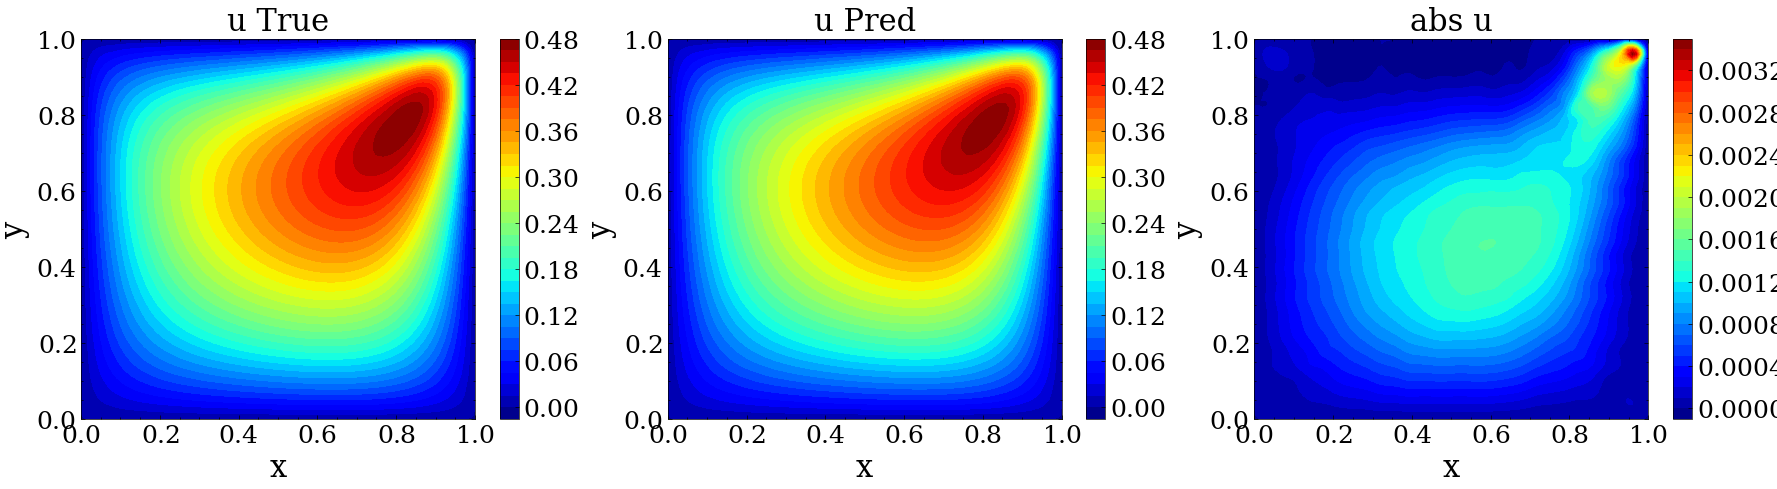

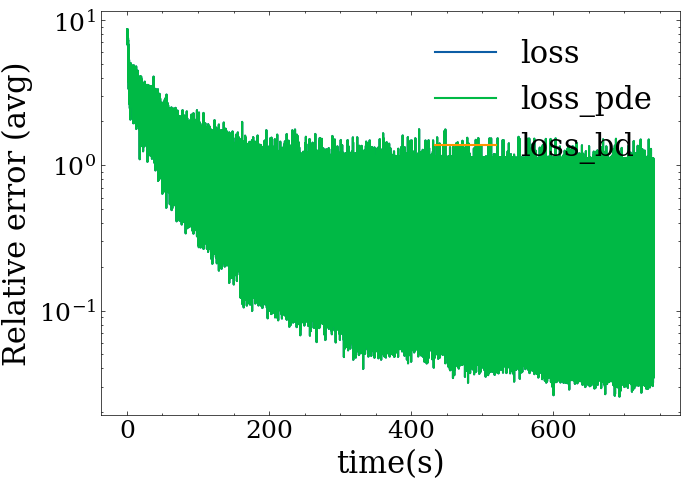

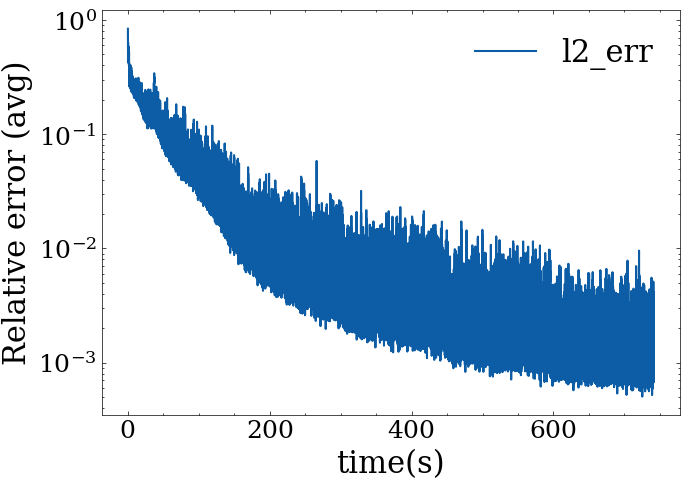

In [3]:
from Utils.PlotFigure import Plot
from Solvers.PINN import PINN
from Utils.Losses import * 
myerror = MyLoss().lp_rel
###############################
# load trained model
###############################
solver = PINN.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path='saved_models/cts/', name='model_pinn_final')

###############################
# make prediction
###############################
x_var = Variable(x_test, requires_grad=True).to(device)
u_var = model_trained['u'](x_var)
u_var = mollifer()(u_var, x_var).detach().cpu()
#
print('The l2_err is', myerror(u_var, u_test))

###############################
# show the result
###############################
Plot.show_2d_list(x_test, [u_test, u_var, u_test-u_var], ['u True', 'u Pred', 'abs u'])
##### show the loss
loss_saved = solver.loadLoss(path='saved_models/cts/', name='loss_pinn')
Plot.show_error([loss_saved['time']]*3, 
                [loss_saved['loss'], loss_saved['loss_pde'], loss_saved['loss_bd']],
                ['loss', 'loss_pde', 'loss_bd'])
##### show the error
Plot.show_error([loss_saved['time']], [loss_saved['error']], ['l2_err'])